# **DS Project: Customer Churn Prediction**
- **Name:** Apriza Zicka Rizquina
- **Email:** aprizazickaa@gmail.com

## **Import Library**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import pickle
import joblib
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

## **Load Data**

In [2]:
# Read train data
dt_train = pd.read_csv('Data Train (C2).csv')
dt_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [3]:
# Read test data
dt_test = pd.read_csv('Data Test (C2).csv')
dt_test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


## **Feature Encoding**

In [4]:
def label_enc(data, col):
  from sklearn import preprocessing
  le = preprocessing.LabelEncoder()
  le.fit(data[col])
  data[col] = le.transform(data[col])
  return data[col]

In [5]:
dt_train['state'] = label_enc(dt_train, 'state')
dt_train['area_code'] = label_enc(dt_train, 'area_code')
dt_train['international_plan'] = label_enc(dt_train, 'international_plan')
dt_train['voice_mail_plan'] = label_enc(dt_train, 'voice_mail_plan')
dt_train['churn'] = label_enc(dt_train, 'churn')

## **Define Train-Test Data and Target Variable**

In [6]:
X = dt_train.drop("churn", axis=1)
y = dt_train["churn"]

In [7]:
X

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,35,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
1,31,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
2,35,84,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
3,36,75,1,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
4,19,121,2,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,26,83,1,0,0,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0
4246,49,73,0,0,0,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3
4247,27,75,0,0,0,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1
4248,11,50,0,0,1,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2


In [8]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4245    0
4246    0
4247    0
4248    0
4249    0
Name: churn, Length: 4250, dtype: int32

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 64)

## **Build Model**
First, we will build the model using a Random Forest with the original (imbalanced) data. This is to observe what happens when we proceed without applying any resampling techniques.

- Random Forest

In [10]:
rfc_model = RandomForestClassifier(max_depth=2)
rfc_model.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
acc_rfc = rfc_model.score(X_test, y_test)
print("Random Forest accuracy:", acc_rfc)
print(classification_report(y_test, y_pred_rfc, labels=[0,1]))

Random Forest accuracy: 0.8564705882352941
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       728
           1       0.00      0.00      0.00       122

    accuracy                           0.86       850
   macro avg       0.43      0.50      0.46       850
weighted avg       0.73      0.86      0.79       850



c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

The accuracy looks good, but when we examine the classification report, the precision, F1-scores, and recall between the two classes are very imbalance.

### Resampling using SMOTE
We use an oversampling method to balance the data. SMOTE is one of the techniques that can generate synthetic examples of the minority class to help the model learn from a more balanced dataset.

In [11]:
smote = SMOTE(sampling_strategy='minority') 
x_resampled, y_resampled = smote.fit_resample(X,y)
y_resampled.value_counts()

churn
0    3652
1    3652
Name: count, dtype: int64

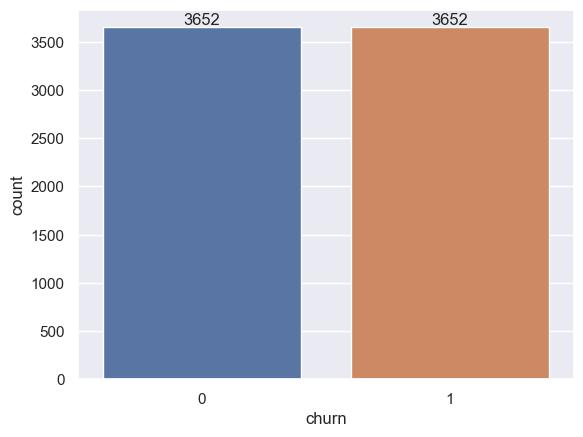

In [12]:
#count the churn
sns.set_theme(style="darkgrid")
ax = sns.countplot(dt_train, x=y_resampled)
for container in ax.containers:
    ax.bar_label(container)

### Splitting Resample Data

In [13]:
xr_train, xr_test, yr_train, yr_test = train_test_split(x_resampled, y_resampled, test_size=0.2)

- Random forest (resampled)

In [14]:
rfc_model_r = RandomForestClassifier()
rfc_model_r.fit(xr_train, yr_train)

yr_pred_rfc = rfc_model_r.predict(xr_test)

rfc_scores = cross_val_score(rfc_model_r, xr_train, yr_train, cv=5, scoring='accuracy')
rfc_acc_r = rfc_model_r.score(xr_test, yr_test)

print(f"Cross-validation scores: {rfc_scores}")
print(f"Mean cross-validation score: {rfc_scores.mean():.4f}")
print(f"Random Forest accuracy on test set: {rfc_acc_r:.4f}")

print(classification_report(yr_test, yr_pred_rfc, labels=[0,1]))

Cross-validation scores: [0.92643285 0.92472198 0.92215569 0.93236301 0.91695205]
Mean cross-validation score: 0.9245
Random Forest accuracy on test set: 0.9405
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       728
           1       0.98      0.90      0.94       733

    accuracy                           0.94      1461
   macro avg       0.94      0.94      0.94      1461
weighted avg       0.94      0.94      0.94      1461



Based on the results, the Random Forest model demonstrates a strong fit to the training data, as indicated by a mean cross-validation score of 0.9245 across 5 folds. This suggests that the model generalizes well during training. When evaluated on the unseen test data, the model achieved an accuracy of 0.9405, which is slightly higher than the cross-validation mean, indicating that the model is not overfitting and performs consistently on new, unseen data.

- Decision Tree (resampled)

In [15]:
# Train
dt_model_r = DecisionTreeClassifier()
dt_model_r.fit(xr_train, yr_train)

# Predict with threshold adjustment
yr_pred_dt = dt_model_r.predict(xr_test)

dt_scores = cross_val_score(dt_model_r, xr_train, yr_train, cv=5, scoring='accuracy')
dt_acc_r = dt_model_r.score(xr_test, yr_test)

# Evaluate
print(f"Cross-validation scores: {dt_scores}")
print(f"Mean cross-validation score: {dt_scores.mean():.4f}")
print(f"Decision tree accuracy on test set: {dt_acc_r:.4f}")

print(classification_report(yr_test, yr_pred_dt, labels=[0,1]))

Cross-validation scores: [0.85115483 0.85457656 0.85885372 0.85787671 0.86558219]
Mean cross-validation score: 0.8576
Decision tree accuracy on test set: 0.8665
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       728
           1       0.85      0.90      0.87       733

    accuracy                           0.87      1461
   macro avg       0.87      0.87      0.87      1461
weighted avg       0.87      0.87      0.87      1461



The Decision Tree model demonstrates reasonably good predictive performance, achieving a mean cross-validation score of 0.8576 across 5 folds. This indicates that the model has learned meaningful patterns from the training data while maintaining a decent generalization ability. When evaluated on the unseen validation set, the model reached an accuracy of 0.8665, suggesting that it performs slightly better on new data and does not show signs of overfitting.

- Xgboost (resampled)

In [16]:
# XGBoost
xgb_model_r = xgb.XGBClassifier()
xgb_model_r.fit(xr_train, yr_train)

yr_pred_xgb = xgb_model_r.predict(xr_test)

xgb_scores = cross_val_score(xgb_model_r, xr_train, yr_train, cv=5, scoring='accuracy')
xgb_acc_r = xgb_model_r.score(xr_test, yr_test)

# Evaluate model
print(f"Cross-validation scores: {xgb_scores}")
print(f"Mean cross-validation score: {xgb_scores.mean():.4f}")
print(f"XGboost accuracy on test set: {xgb_acc_r:.4f}")

print(classification_report(yr_test, yr_pred_xgb))

Cross-validation scores: [0.92130026 0.93156544 0.92386655 0.92979452 0.92722603]
Mean cross-validation score: 0.9268
XGboost accuracy on test set: 0.9425
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       728
           1       0.96      0.92      0.94       733

    accuracy                           0.94      1461
   macro avg       0.94      0.94      0.94      1461
weighted avg       0.94      0.94      0.94      1461



The XGBoost model achieved a mean cross-validation score of 0.9268, indicating strong and consistent performance during training across multiple validation folds. When evaluated on the unseen test set, the model reached a higher accuracy of 0.9425, suggesting that it generalizes very well and is not overfitting. The close alignment between cross-validation and test accuracy demonstrates the model's robustness and reliability on new data.

## **Evaluation**

- Random Forest

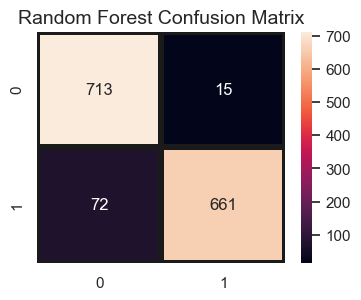

In [17]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(yr_test, yr_pred_rfc),
                annot=True, fmt = "d", linecolor="k", linewidths=3)

plt.title("Random Forest Confusion Matrix",fontsize=14)
plt.show()

The Random Forest model demonstrates excellent performance, correctly predicting 713 negative cases and 661 positive cases of churn. It makes only a small number of errors, with 15 false positives and 72 false negatives, indicating that the model is highly reliable and well-balanced for the classification task.

- Decision Tree

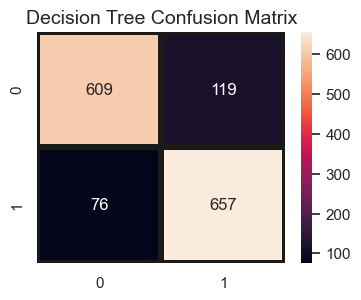

In [18]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(yr_test, yr_pred_dt),
                annot=True, fmt = "d", linecolor="k", linewidths=3)

plt.title("Decision Tree Confusion Matrix",fontsize=14)
plt.show()

The Decision Tree model shows good performance, correctly predicting 609 negative cases and 657 positive cases.  However, it also produces 119 false positives and 76 false negatives, indicating that while the model performs reasonably well, it is less balanced and slightly less accurate compared to the Random Forest model.

- XGBoost

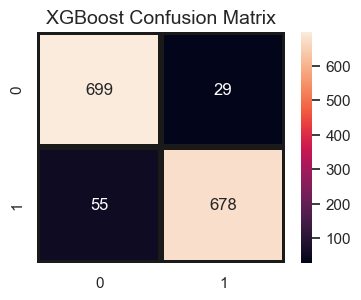

In [19]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(yr_test, yr_pred_xgb),
                annot=True, fmt = "d", linecolor="k", linewidths=3)

plt.title("XGBoost Confusion Matrix",fontsize=14)
plt.show()

The XGBoost model demonstrates outstanding performance, correctly predicting 699 negative cases and 678 positive cases. It only makes a small number of errors, with 29 false positives and 55 false negatives, indicating a very strong ability to distinguish between classes. This results in a high overall accuracy, along with excellent precision and recall, making XGBoost the best-performing model among those evaluated. The low number of misclassifications highlights the model's robustness and reliability for churn prediction.



### ROC

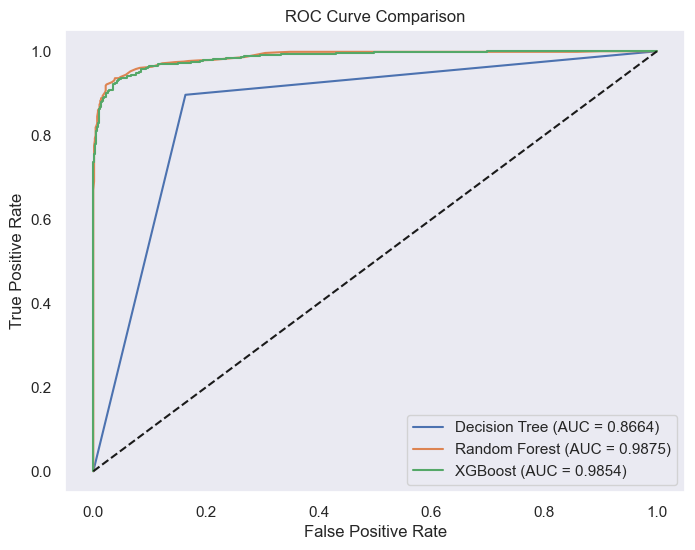

In [20]:
# 1. Predict probabilities for each model
yr_proba_dt = dt_model_r.predict_proba(xr_test)[:, 1]  
yr_proba_rf = rfc_model_r.predict_proba(xr_test)[:, 1]  
yr_proba_xgb = xgb_model_r.predict_proba(xr_test)[:, 1]

# 2. Calculate ROC curves
fpr_dt, tpr_dt, _ = roc_curve(yr_test, yr_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(yr_test, yr_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(yr_test, yr_proba_xgb)

# 3. Calculate ROC AUC scores
roc_auc_dt = roc_auc_score(yr_test, yr_proba_dt)
roc_auc_rf = roc_auc_score(yr_test, yr_proba_rf)
roc_auc_xgb = roc_auc_score(yr_test, yr_proba_xgb)

# 4. Plot ROC Curves
plt.figure(figsize=(8,6))

plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Random guessing line
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Based on the ROC curve analysis, both XGBoost and Random Forest achieve an AUC score of 0.98, indicating excellent ability to distinguish between churn and non-churn cases. However, when we examine the classification evaluation metrics, XGBoost performs slightly better overall. This suggests that XGBoost is particularly effective in classifying churn, with near-perfect predictive performance

### Feature Importance

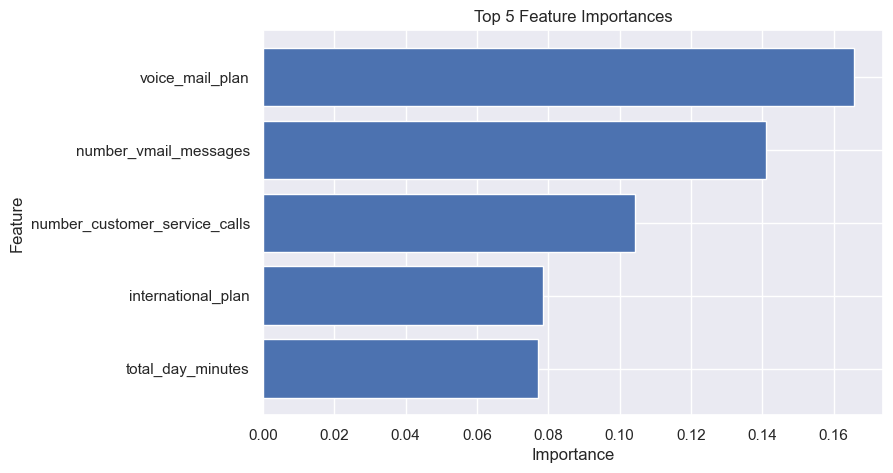

In [21]:
importances = xgb_model_r.feature_importances_

feature_importance = pd.DataFrame({'Feature': xr_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 5 top features
top_5_features = feature_importance.head(5)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(top_5_features['Feature'], top_5_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

**voice_mail_plan** is the most important feature in this model because it contributes the most to model's performance.

## **Save The Model**

In [22]:
pickle.dump(xgb_model_r, open('xgb_model_smote.sav', 'wb'))
pickle.dump(xgb_model_r, open('xgb_model_smote.pkl', 'wb'))

In [23]:
# load model
model = joblib.load('xgb_model_smote.sav')
data = pd.read_csv('Data Test (C2).csv')

# drop column and encoding feature
data = data.iloc[:, 1:]

for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].astype('category').cat.codes

# predict
predictions = model.predict(data)

# add new column
data['Prediction'] = predictions

# save
data.to_csv('new_data_with_predictions.csv', index=False)

print("Predictions added and saved successfully!")


Predictions added and saved successfully!


## **Conclusion**

The churn prediction analysis identified XGBoost as the top-performing model among those evaluated. Both XGBoost and Random Forest achieved an excellent AUC score of 0.98 on cross-validation and test sets, indicating outstanding performance in distinguishing between customers who churn and those who stay. However, XGBoost showed a slightly higher AUC than Random Forest, making it the most effective model in this analysis.

The model demonstrated high **accuracy (94%)**, precision, and recall, with a small number of misclassifications, confirming its robustness and reliability for real-world application.

Feature importance analysis revealed that the **voice_mail_plan** feature was the most influential factor in predicting churn. This suggests that having or not having a voicemail plan is strongly associated with a customer's likelihood of leaving. This insight can inform more effective, targeted customer retention strategies.

Overall, the XGBoost model offers a powerful and accurate solution for churn prediction, enabling the business to proactively address at-risk customers and improve customer loyalty efforts.
